In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm
import random


In [3]:
import re
import unicodedata

import nltk
from nltk.corpus import wordnet


def normalize(text):
    normalized_text = normalize_unicode(text)
    normalized_text = normalize_number(normalized_text)
    normalized_text = lower_text(normalized_text)
    return normalized_text


def lower_text(text):
    return text.lower()


def normalize_unicode(text, form='NFKC'):
    normalized_text = unicodedata.normalize(form, text)
    return normalized_text


def lemmatize_term(term, pos=None):
    if pos is None:
        synsets = wordnet.synsets(term)
        if not synsets:
            return term
        pos = synsets[0].pos()
        if pos == wordnet.ADJ_SAT:
            pos = wordnet.ADJ
    return nltk.WordNetLemmatizer().lemmatize(term, pos=pos)


def normalize_number(text):
    """
    pattern = r'\d+'
    replacer = re.compile(pattern)
    result = replacer.sub('0', text)
    """
    # 連続した数字を0で置換
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text

ModuleNotFoundError: No module named 'nltk'

In [3]:
shortened = {
    '\'m': ' am',
    '\'re': ' are',
    'don\'t': 'do not',
    'doesn\'t': 'does not',
    'didn\'t': 'did not',
    'won\'t': 'will not',
    'wanna': 'want to',
    'gonna': 'going to',
    'gotta': 'got to',
    'hafta': 'have to',
    'needa': 'need to',
    'outta': 'out of',
    'kinda': 'kind of',
    'sorta': 'sort of',
    'lotta': 'lot of',
    'lemme': 'let me',
    'gimme': 'give me',
    'getcha': 'get you',
    'gotcha': 'got you',
    'letcha': 'let you',
    'betcha': 'bet you',
    'shoulda': 'should have',
    'coulda': 'could have',
    'woulda': 'would have',
    'musta': 'must have',
    'mighta': 'might have',
    'dunno': 'do not know',
}

shortened_re = re.compile('(?:' + '|'.join(map(lambda x: '\\b' + x + '\\b', shortened.keys())) + ')')

# example
sentence = 'I\'m'
sentence = shortened_re.sub(lambda x: shortened[x.group(0)], sentence)

In [4]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()


from nltk.stem.wordnet import WordNetLemmatizer
wnl = WordNetLemmatizer()

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
#set random seed
def set_seed(seed: int = 123):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
    
set_seed(123)

In [7]:
#read data_files
train = pd.read_csv('../input/signate-stcup-2020/train.csv')
test = pd.read_csv('../input/signate-stcup2020-new/test.csv')
submission = pd.read_csv('../input/signate-stcup2020-new/submit_sample.csv')

In [8]:
def check_except_words(sentence):
    except_words = ["e.g.", "node. ", "Approx. ", "St.", "etc. ", "i.e. ", "Sr. ", "ex. ", "U.S. ", "incl. ", ". (", "I.e. " ]
    for word in except_words:
        if word in sentence:
            return True
    return False

In [9]:
def split_sentences(df):
    sentences = []
    ids = []
    jobs = []
    for n in range(len(df)):
        if ". " in df.description.iloc[n]:
            multi_sentence = []
            if not check_except_words(df.description.iloc[n]):
                multi_sentence.append(list(map(str,df.description.iloc[n].split(". "))))
                for sentence in multi_sentence[0]:
                    sentences.append(sentence)
                    ids.append(df.iloc[n].id)
                    jobs.append(df.iloc[n].jobflag)
    special_dataset = pd.DataFrame({"id": ids, "description": sentences, "jobflag": jobs})
    return special_dataset

In [10]:
def drop_duplicated_sentence(train):
    df = train.copy()
    #df_dup = df[df.duplicated(subset=['description', 'jobflag'])]
    #df_evil = df[df.duplicated(subset='description', keep=False)]
    
    for n in tqdm(range(len(df))):
        df.description.iloc[n] = normalize(df.description.iloc[n])
        df.description.iloc[n] = shortened_re.sub(lambda x: shortened[x.group(0)], df.description.iloc[n])
        sentence = ""
        for word in df.description.iloc[n].strip(".:;'&%$#=~|!'<>?*+`@/,_][}{").split(" "):
            word = stemmer.stem(word)
            word = wnl.lemmatize(word)
            sentence += word + " "
        df.description.iloc[n] = sentence[:-1]
        
    df_dup = df[df.duplicated(subset=['description','jobflag'])]
    new_df = df.drop_duplicates(subset=['description','jobflag'])
    new_index = new_df.index
    # ただの表記揺れだが、取り除いておく
    new_train = train.reindex(index=new_index)
    
    df_evil = new_df[new_df.duplicated(subset='description', keep=False)]
    evil_index = df_evil.index
    # descriptionが同一だがjobflagが不一致
    df_evil = train.reindex(index=evil_index)
    print(f'there are {len(df_dup)} duplicates and {len(df_evil)} evil-data... ')
    
    df_clean = df.drop_duplicates(subset=['description','jobflag'])
    df_clean = df_clean.drop_duplicates(subset='description', keep=False)
    clean_index = df_clean.index
    # 全部取り除いたやつ
    clean_train = train.reindex(index=clean_index)
    
    return new_train, df_evil, clean_train

In [11]:
clean_and_evil, evil, clean = drop_duplicated_sentence(train)

100%|██████████| 2931/2931 [00:06<00:00, 458.45it/s]

there are 35 duplicates and 16 evil-data... 


In [12]:
evil.head(5)

,id,description,jobflag
96,96,Use predictive modeling to increase and optimi...,1
430,430,Collaboration: Work with your peers within you...,4
449,449,Effectively explain technical concepts at all ...,2
797,797,Assess the effectiveness and accuracy of new d...,2
798,798,Collaboration: Work with your peers within you...,3


In [13]:
additional_train = split_sentences(clean)
train = pd.concat([clean, additional_train])
train = train.reset_index(drop=True)
_, _, train = drop_duplicated_sentence(train)
train = train.reset_index(drop=True)
train.to_csv('new_train.csv')
train

100%|██████████| 3112/3112 [00:03<00:00, 809.20it/s]


there are 4 duplicates and 2 evil-data... 


,id,description,jobflag
0,0,"Executes and writes portions of testing plans,...",2
1,1,Maintain Network Performance by assisting with...,3
2,2,Supports the regional compliance manager with ...,4
3,3,Keep up to date with local and national busine...,1
4,4,Assist with Service Organization Control (SOC)...,4
...,...,...,...
3101,2659,Demonstrate expertise to deliver functional an...,4
3102,2673,Develop high-performance algorithms for predic...,1
3103,2673,Testing and implementing these algorithms in s...,1
3104,2865,Mine and analyze company data to drive optimiz...,1


In [14]:
train.head(3)

,id,description,jobflag
0,0,"Executes and writes portions of testing plans,...",2
1,1,Maintain Network Performance by assisting with...,3
2,2,Supports the regional compliance manager with ...,4


In [15]:
def split_sentences_for_test(df):
    sentences = []
    ids = []
    jobs = []
    for n in range(len(df)):
        if ". " in df.description.iloc[n]:
            multi_sentence = []
            if not check_except_words(df.description.iloc[n]):
                multi_sentence.append(list(map(str,df.description.iloc[n].split(". "))))
                for sentence in multi_sentence[0]:
                    sentences.append(sentence)
                    ids.append(df.iloc[n].id)
    special_dataset = pd.DataFrame({"id": ids, "description": sentences})
    return special_dataset

In [16]:
additional_test = split_sentences_for_test(test)
test = pd.concat([test, additional_test])
test.to_csv('test_ex.csv', index=False)

In [17]:
job_dict = {1: "Data Scientist",2: "ML Engineer", 
            3: "Software Engineer",4: "Consultant"}
job_dict_init = {1:"DS",2:"MLEng",3:"SE",4:"Consul"}
num_classes = len(job_dict)
job_dict

{1: 'Data Scientist',
 2: 'ML Engineer',
 3: 'Software Engineer',
 4: 'Consultant'}

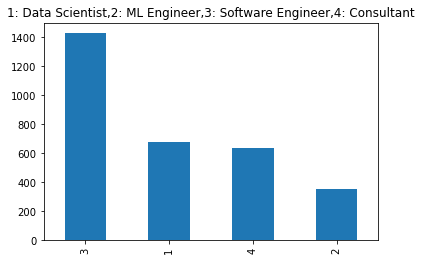

In [18]:
#visualize the data
plt.figure()
plt.title("1: Data Scientist,2: ML Engineer,3: Software Engineer,4: Consultant")
train.jobflag.value_counts().plot(kind="bar")

pred_1 = pd.read_csv('../input/first-fn/bert_electra_csroberta_roberta_tapt_bt_sub.csv')
pred_2 = pd.read_csv('../input/first-fn/bert_electra_csroberta_roberta_tapt_albert_xlnet_bt_sub.csv')
pred_1 = pred_1["3"]
pred_2 = pred_2["3"]
score = accuracy_score(pred_1, pred_2)
print(score)

In [19]:
#Jaccard係数(overlap coefficiant)の計算アルゴリズム
def jaccard_similarity_coefficient(df_a,df_b):
    vectorizer = CountVectorizer()
    
    vectorizer.fit_transform(df_a.description)
    list_a = vectorizer.vocabulary_.keys()
    
    vectorizer.fit_transform(df_b.description)
    list_b = vectorizer.vocabulary_.keys()
    
    #集合Aと集合Bの積集合(set型)を作成
    set_intersection = set.intersection(set(list_a), set(list_b))
    #集合Aと集合Bの積集合の要素数を取得
    num_intersection = len(set_intersection)
 
    #集合Aと集合Bの和集合(set型)を作成
    set_union = set.union(set(list_a), set(list_b))
    #集合Aと集合Bの和集合の要素数を取得
    num_union = len(set_union)
 
    #積集合の要素数を和集合の要素数で割って
    #Jaccard係数を算出
    try:
        return float(num_intersection) / num_union
    except ZeroDivisionError:
        return 1.0 

In [20]:
jaccard = jaccard_similarity_coefficient(train,test) 
print(jaccard) # J(train,test) = 0.4408504452117027

0.4410909090909091


In [21]:
def caluculate_jaccard(df_paths, original_df):
    df_a = original_df
    j_dict = {}
    for df_path in df_paths:
        df_b = pd.read_csv(df_path).dropna()
        path = df_path.split('-')[-1].split('.')[0]
        j_score = jaccard_similarity_coefficient(df_a, df_b)
        j_dict[path] = j_score
    return j_dict

In [22]:
def get_jaccard_matrix(df_path):
    j_dict = {}
    for df_a_path in tqdm(df_paths):
        df_a = pd.read_csv(df_a_path).dropna()
        path_a = df_a_path.split('-')[-1].split('.')[0]
        for df_b_path in df_paths:
            df_b = pd.read_csv(df_b_path).dropna()
            path_b = df_b_path.split('-')[-1].split('.')[0]
            j_score = jaccard_similarity_coefficient(df_a, df_b)
            j_dict[df_a_path + df_b_path] = j_score
    j_matrix = np.array(list(j_dict.values())).reshape(len(df_paths),len(df_paths))
    return j_matrix

In [ ]:
df_paths = [
           "../input/btaugmented-for-holdout/stcup2020-train-google-el.csv",
           "../input/btaugmented-for-holdout/stcup2020-train-google-ru.csv",
           "../input/btaugmented-for-holdout/stcup2020-train-google-sw.csv",
           "../input/btaugmented-for-holdout/stcup2020-train-google-vi.csv",
           "../input/bt-alibaba-holdout/stcup2020-train-alibaba-tr.csv",
           "../input/bt-alibaba-holdout/stcup2020-train-alibaba-th.csv",
            "../input/bt-bimg-holdout/stcup2020-train-bing-fr.csv"
]
j_dict = caluculate_jaccard(df_paths, train)
print(j_dict)

In [ ]:
j_matrix = get_jaccard_matrix(df_paths)
plt.imshow(j_matrix)
plt.colorbar()
plt.show()